In [1]:
import re
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from intervaltree import IntervalTree
from datetime import date

from io import BytesIO
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import PatternFill, Font, Alignment

In [2]:
def spaced_str(var):
  """Inserts spaces before capitalized letters.

  Args:
    word: The word to be modified.

  Returns:
    str: The string with spaces.
  """

  if isinstance(var, str):
    word = var
    idx_caps = [m.start() for m in re.finditer(r'[A-Z]', word)]

    # Inserts spaces before captalized letters except for the first one
    for i, idx in enumerate(idx_caps[1:]):
      word = word[:idx+i] + ' ' + word[idx+i:]

    return word
  return np.nan

# Building a tree of intervals from df_workout
def build_interval_tree(df_workout):
    df_workout['startDate'] = pd.to_datetime(df_workout['startDate'])
    df_workout['endDate']   = pd.to_datetime(df_workout['endDate'])

    tree = IntervalTree()
    for _, row in df_workout.iterrows():
        start = row['startDate'] - pd.Timedelta(seconds=1)
        end = row['endDate'] + pd.Timedelta(seconds=1)
        tree.addi(start, end, row['id'])
    return tree

# Associating IDs using our tree
def assign_workout_id(df, interval_tree):
    df['startDate'] = pd.to_datetime(df['startDate'])
    ids = []
    for time in df['startDate']:
        # Buscar intervalos que contêm o horário atual
        matches = interval_tree[time]
        # Adicionar o ID correspondente (ou None se não houver match)
        ids.append(next(iter(matches)).data if matches else None)
    df['id'] = ids
    return df

In [3]:
def parse_large_xml(file_path, tag, attribute=None, values=[]):
    """
    Lê um XML grande de forma eficiente, processando elementos específicos.
    
    Args:
    - file_path: Caminho para o arquivo XML.
    - tag: Tag que você deseja extrair (ex.: 'Record').
    - attribute: Atributo que você deseja filtrar (opcional).
    - values: Valor do atributo que você deseja filtrar (opcional).
    
    Returns:
    - DataFrame contendo os dados extraídos.
    """
    rows = []
    for event, elem in ET.iterparse(file_path, events=('end',)):
        if elem.tag == tag:
            if attribute and attribute in elem.attrib:
                if elem.attrib[attribute] in values:
                    rows.append(elem.attrib)  # Extrai os atributos como dicionário
            elif not attribute:
                rows.append(elem.attrib)  # Extrai os atributos como dicionário
            elem.clear()  # Libera memória ao descartar o elemento processado
    return pd.DataFrame(rows)

In [4]:
file_path = './export/export_dea/apple_health_export/export.xml'
print(1)
att_list = ['HKQuantityTypeIdentifierHeartRate', 'HKQuantityTypeIdentifierActiveEnergyBurned'] 
df_heart_cal = parse_large_xml(file_path, tag='Record', attribute='type', values=att_list)
print(2)

df_heart_cal = df_heart_cal.drop(['sourceName', 'sourceVersion', 'device', 'unit', 'creationDate', 'endDate'], axis=1)
print(3)

df_workout = parse_large_xml(file_path, tag='Workout')
df_workout = df_workout.drop(columns=['durationUnit', 'sourceName', 'sourceVersion'], axis=1)
print(4)

df_activity = parse_large_xml(file_path, tag='ActivitySummary')
df_activity = df_activity[['dateComponents', 'activeEnergyBurned', 'activeEnergyBurnedGoal', 'appleExerciseTime']]

1
2
3
4


In [5]:
df_workout['duration'] = df_workout['duration'].apply(lambda value: int(float(value)) if pd.notna(value) else np.nan)
df_workout['duration'] = df_workout['duration'].astype('Int64')

df_activity['activeEnergyBurned'] = df_activity['activeEnergyBurned'].apply(lambda value: int(float(value)) if pd.notna(value) else np.nan)
df_activity['activeEnergyBurned'] = df_activity['activeEnergyBurned'].astype('Int64')
df_activity['appleExerciseTime']  = df_activity['appleExerciseTime'].astype('Int64')

In [6]:
df_activity['activeEnergyBurnedGoal'] = df_activity['activeEnergyBurnedGoal'].astype('Int64')

In [7]:
search_year = None
# search_year = 2021

In [8]:
today        = date.today()
this_month   = today.month

if not search_year:
    search_year  = today.year if this_month == 12 else today.year - 1
    
df_workout   = df_workout[df_workout['startDate'].str.startswith(f"{search_year}")].reset_index(drop=True)
df_heart_cal = df_heart_cal[df_heart_cal['startDate'].str.startswith(f"{search_year}")].reset_index(drop=True)
df_activity  = df_activity[df_activity['dateComponents'].str.startswith(f"{search_year}")].reset_index(drop=True)

Getting birthday and gender data:

In [9]:
# bday  = df_metrics.iloc[:, 1].dropna()
# bday  = pd.to_datetime(bday.iloc[0])

# age   = today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))

In [10]:
# bio_sex = df_metrics.iloc[:, 2].dropna()
# bio_sex = bio_sex.iloc[0].split('Sex')[1]

In [11]:
# df_metrics = df_metrics.iloc[2:, :]

In [12]:
# df_metrics_old_years = df_metrics[~df_metrics['dateComponents'].str.startswith(f"{search_year}")].reset_index(drop=True)
# df_metrics           = df_metrics[df_metrics['dateComponents'].str.startswith(f"{search_year}")].reset_index(drop=True)

In [13]:
# df['type'] = df['type'].str.split('Identifier').where(df['type'].notnull(), np.nan).str[1]
df_workout['workoutActivityType'] = df_workout['workoutActivityType'].str.split('ActivityType').where(df_workout['workoutActivityType'].notnull(), np.nan).str[1]

In [14]:
df_workout['workoutActivityType'] = df_workout['workoutActivityType'].apply(spaced_str)

Separating Heart Rate data from Workout data:

In [15]:
df_heart_rate = df_heart_cal.loc[df_heart_cal['type'].str.endswith('HeartRate')].reset_index(drop=True)
df_calories   = df_heart_cal.loc[df_heart_cal['type'].str.endswith('ActiveEnergyBurned')].reset_index(drop=True)
# df_workout    = df.loc[~df['workoutActivityType'].isna()].reset_index(drop=True)

In [16]:
df_heart_rate = df_heart_rate.rename(columns={'value': 'heart_rate'})
df_calories = df_calories.rename(columns={'value': 'calories'})

In [17]:
df_heart_rate['heart_rate'] = df_heart_rate['heart_rate'].astype(float).astype(int)
df_calories['calories'] = df_calories['calories'].astype(float)

In [18]:
ids = pd.Series(range(1, len(df_workout) + 1))
df_workout = pd.concat([ids.rename('id'), df_workout], axis=1)

Associating each Heart Rate to an Exercise

In [19]:
workout_tree = build_interval_tree(df_workout)

df_heart_rate = assign_workout_id(df_heart_rate, workout_tree)
df_calories   = assign_workout_id(df_calories, workout_tree)

In [20]:
df_heart_rate = df_heart_rate[~df_heart_rate['id'].isna()].reset_index(drop=True)
df_calories   = df_calories[~df_calories['id'].isna()].reset_index(drop=True)

Creating important columns:

In [21]:
df_calories = df_calories.groupby(['id']).agg({'calories': 'sum'})

In [22]:
df_full = pd.merge(df_workout, df_heart_rate[['id', 'heart_rate']], on='id', how='left')
# df_full = pd.merge(df_full, df_calories, on='id', how='left')

Adding date columns:

In [23]:
months_dict = {1: 'JAN', 2: 'FEB', 3: 'MAR', 4: 'APR', 5: 'MAY', 6: 'JUN', 
            7: 'JUL', 8: 'AUG', 9: 'SEP', 10: 'OCT', 11: 'NOV', 12: 'DEC'}

df_full['date']  = df_full['startDate'].dt.date
df_full['month'] = df_full['startDate'].dt.month
df_full['year']  = df_full['startDate'].dt.year
df_full['month_name'] = df_full['month'].map(months_dict)

df_activity['dateComponents'] = pd.to_datetime(df_activity['dateComponents'])
df_activity['month'] = df_activity['dateComponents'].dt.month
df_activity['month_name'] = df_activity['month'].map(months_dict)

Defining Heart Rate info necessary:

In [24]:
col_names_hr = ['id', 'workoutActivityType', 'duration', 'date','month', 'month_name' ]

In [25]:
df_hr_mean = df_full.groupby(col_names_hr).agg({'heart_rate': 'mean'})
df_hr_mean = df_hr_mean.reset_index()
df_hr_mean = df_hr_mean.rename(columns={'heart_rate': 'heart_rate_mean'})

df_hr_mean['heart_rate_mean'] = df_hr_mean['heart_rate_mean'].apply(lambda value: int(value) if not pd.isna(value) else value)

In [26]:
serie_hr_max = df_full.groupby(col_names_hr).agg({'heart_rate': 'max'}).reset_index(drop=True)
serie_hr_max.columns = ['heart_rate_max']

df_v1 = pd.concat([df_hr_mean, serie_hr_max], axis=1)

In [27]:
df_v2 = pd.merge(df_v1, df_calories, on='id', how='left')
df_v2['calories'] = df_v2['calories'].fillna(0)
df_v2['calories'] = df_v2['calories'].astype(int)

Results:

Top sports:

In [28]:
sports_by_count    = df_v2['workoutActivityType'].value_counts()
total_sports       = len(sports_by_count)
top_sport_by_count = sports_by_count.idxmax()
count_top_sport    = sports_by_count.max()

top_sports_by_time = df_v2.groupby(by=['workoutActivityType']).agg({'duration': 'sum', 'calories': 'sum', 'date': 'count'}).sort_values(by='duration', ascending=False)

top_sport_by_time       = top_sports_by_time.idxmax().iloc[0]
time_top_sport          = top_sports_by_time.max().iloc[0]
count_top_sport_by_time = sports_by_count[top_sport_by_time]

top_5_sports_by_time    = top_sports_by_time.iloc[:5, :].reset_index()
top_5_sports_by_time.columns = ['Sport', 'Total Minutes', 'Total Calories', 'Sessions']

Heart Rate:

In [29]:
highest_heart_rate = df_v2.loc[df_v2['heart_rate_max'].idxmax(), :]
heart_rate_per_sport = df_v2.groupby(['workoutActivityType']).agg({'heart_rate_mean': 'mean'})
sport_highest_avg_heart_rate = heart_rate_per_sport.idxmax().iloc[0]
highest_avg_heart_rate = int(heart_rate_per_sport.max().iloc[0])

Calories:

In [30]:
calories_per_sport = df_v2.groupby(['workoutActivityType']).agg({'calories': 'mean'})
sport_highest_avg_calories = calories_per_sport.idxmax().iloc[0]
highest_avg_calories = int(calories_per_sport.max().iloc[0])

Total time exercising and goals:

In [31]:
exercise_total_time = top_sports_by_time['duration'].sum()
exercise_time_per_day = int(exercise_total_time/365)
exercise_total_days = len(df_v2['date'].drop_duplicates())
exercise_total_calories = top_sports_by_time['calories'].sum()
exercise_calories_per_day = int(exercise_total_calories/365)

In [32]:
energy_goal_check = df_activity[(df_activity['activeEnergyBurned'] >= df_activity['activeEnergyBurnedGoal']) & (df_activity['activeEnergyBurnedGoal'] > 0)].reset_index(drop=True)
days_energy_goal_check = energy_goal_check.shape[0]

# start_date = date(date.today().year, 1, 1)
# days_since_start_of_year = (today - start_date).days
# percent_goal_check_so_far = round(days_energy_goal_check/days_since_start_of_year*100, 2)
percent_goal_check_so_far = round(days_energy_goal_check/365*100, 2)

Top day of exercises:

In [33]:
top_exercise_day_data = df_v2.groupby(['date']).agg({'duration': 'sum', 'calories': 'sum'})
top_exercise_day = top_exercise_day_data.idxmax()['duration']
top_exercise_day_calories = top_exercise_day_data.loc[top_exercise_day, 'calories']
top_exercise_day_time = top_exercise_day_data.loc[top_exercise_day, 'duration']

top_exercise_day_training = df_v2.loc[df_v2['date'] == (top_exercise_day)]
top_exercise_day_training = top_exercise_day_training.rename(
    columns={
        'workoutActivityType': 'Sport',
        'duration': 'Total Minutes',
        'calories': 'Total Calories'
    }
)

Most active day:

In [34]:
top_active_day_data = df_activity.loc[df_activity['activeEnergyBurned'].idxmax(), ['dateComponents', 'activeEnergyBurned', 'appleExerciseTime']]
top_active_day = top_active_day_data['dateComponents']
top_active_day_calories = top_active_day_data['activeEnergyBurned']
top_active_day_time = top_active_day_data['appleExerciseTime']

top_active_day_training = df_v2.loc[df_v2['date'] == (top_active_day)]
top_active_day_training = top_active_day_training.rename(
    columns={
        'workoutActivityType': 'Sport',
        'duration': 'Total Minutes',
        'calories': 'Total Calories'
    }
)

top_active_day_training_none = None

Showing all of the results:

In [35]:
def tsd(num):
    """ Formats a number including thousands separator. """
    return f"{num:,.0f}".replace(",", ".")

MUDAR O NOME DAS VARIAVEIS E AJUSTAR PRA ENTRAR A LINHA 6

In [36]:
row_year_1 = (f'You exercised for {tsd(exercise_total_time)} minutes this year in {exercise_total_days} different days and burned {tsd(exercise_total_calories)} calories!')
row_year_2 = (f'That is an average of {exercise_time_per_day} minutes and {exercise_calories_per_day} calories per day.')

row_sports_1 = (f'And you experimented {total_sports} different sports!')
row_sports_2 = (f'Your top sport by number of registers is: {top_sport_by_count} and you practiced it {count_top_sport} times this year.')

if top_sport_by_count != top_sport_by_time:
    row_sports_3 = (f'But your top sport by time is: {top_sport_by_time} and you practiced it {count_top_sport_by_time} times this year for {tsd(time_top_sport)} minutes.')
else:
    row_sports_3 = (f'And your top sport by time is also: {top_sport_by_time}! You practiced it for {tsd(time_top_sport)} minutes.')

row_sports_4 = (f'You burned an average of {int(top_5_sports_by_time.loc[0, 'Total Calories']/count_top_sport_by_time)} calories per {top_sport_by_time} session.')

row_sports_5 = (f'Your top 5 sports are:')
table_sports_1 = top_5_sports_by_time

In [37]:
row_heart_1 = (f'The sport that makes your heart race is: {sport_highest_avg_heart_rate}!')
row_heart_2 = (f'The average heart rate you get when practicing it is {highest_avg_heart_rate} bpm.')

In [38]:
row_calories_1 = (f'But the sport that really makes you burn is {sport_highest_avg_calories} with an average of {highest_avg_calories} calories per session!')

In [39]:
row_day_1 = (f'The day you exercised the most was {top_exercise_day}.')
row_day_2 = (f'You worked out for {top_exercise_day_time} minutes and burned {int(top_exercise_day_calories)} calories!')

row_day_3 = (f'Exercises that day:')
top_exercise_day_training = top_exercise_day_training.reset_index(drop=True)
table_day_1 = top_exercise_day_training[['Sport', 'Total Minutes', 'Total Calories']]

In [40]:
row_day_4 = (f'Now, your most active day was... {top_active_day}! ')
row_day_5 = (f'Your movement ring reached {tsd(int(top_active_day_calories))} calories and your exercise ring registered {top_active_day_time} minutes!')

if top_active_day_training.empty:
    row_day_6 = 'However, there are no exercises registered for this day...'
    table_day_2 = ''
else:
    top_active_day_training = top_active_day_training.reset_index(drop=True)
    row_day_6 = (f"Exercises that day: ")
    table_day_2 = top_active_day_training[['Sport', 'Total Minutes', 'Total Calories']]

In [41]:
row_goals_1 = (f'You reached your movement goal on {days_energy_goal_check} days this year!')
row_goals_2 = (f'That represents {percent_goal_check_so_far}% of the year!')

row_view_1 = (f'Below you can see your results throughout the year.')

In [42]:
df_activity_per_month = df_activity.groupby(['month', 'month_name']).agg({'appleExerciseTime': 'sum'}).reset_index()
df_activity_per_month['hours'] = df_activity_per_month['appleExerciseTime'].apply(lambda value: round(value/60, 1))

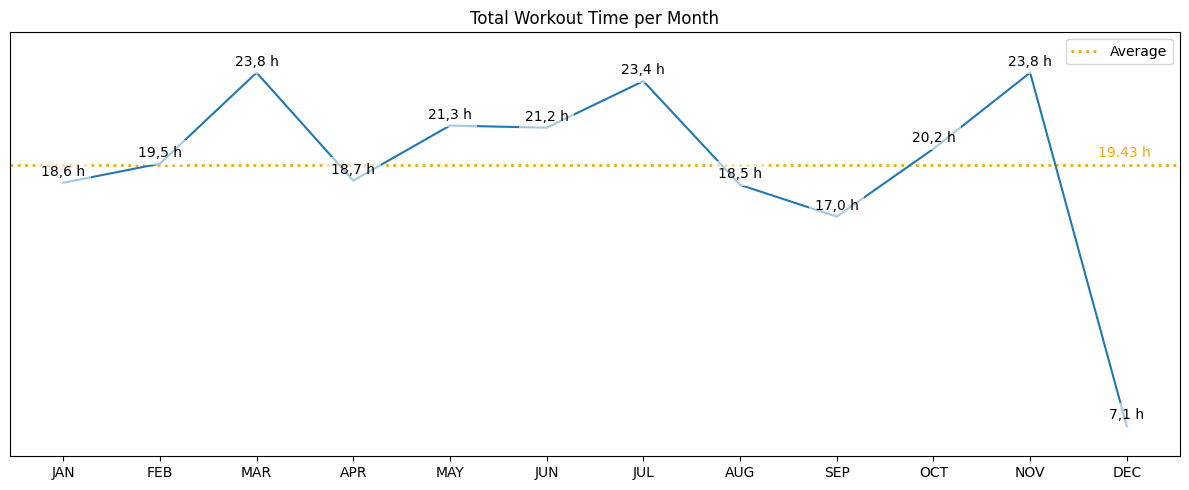

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 5))

mean_value = df_activity_per_month['hours'].mean()
ax1.axhline(mean_value, color='orange', linestyle=':', linewidth=2, label='Average')
ax1.annotate(
    f'{mean_value:.2f} h',  # Texto a ser exibido, ajustado para duas casas decimais
    xy=(0.93, mean_value*1.02),  # Coordenadas (x, y) para posicionar a anotação
    xycoords=('axes fraction', 'data'),  # Define que x usa fração dos eixos e y os dados
    fontsize=10,  # Tamanho da fonte
    color='orange',  # Cor do texto
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.7)  # Fundo branco com leve transparência
)

lp_time_per_month = sns.lineplot(data=df_activity_per_month, x='month_name', y='hours')
ax1.set_xlabel('');
ax1.yaxis.set_visible(False)

y_min = df_activity_per_month['hours'].min()
y_max = df_activity_per_month['hours'].max()
ax1.set_ylim(y_min * 0.8, y_max * 1.08)
ax1.set_title('Total Workout Time per Month')

for i, row in df_activity_per_month.iterrows():
    ax1.annotate(
        text=f"{str(row['hours']).replace('.', ',')} h",  # Texto da anotação
        xy=(row['month_name'], row['hours']),  # Coordenadas do ponto
        xytext=(0, 5),  # Deslocamento em relação ao ponto (x, y)
        textcoords='offset points',  # Usa o deslocamento definido acima
        ha='center', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )


img_buffer_1 = BytesIO()
plt.tight_layout()
plt.savefig(img_buffer_1, format='png', dpi=100)

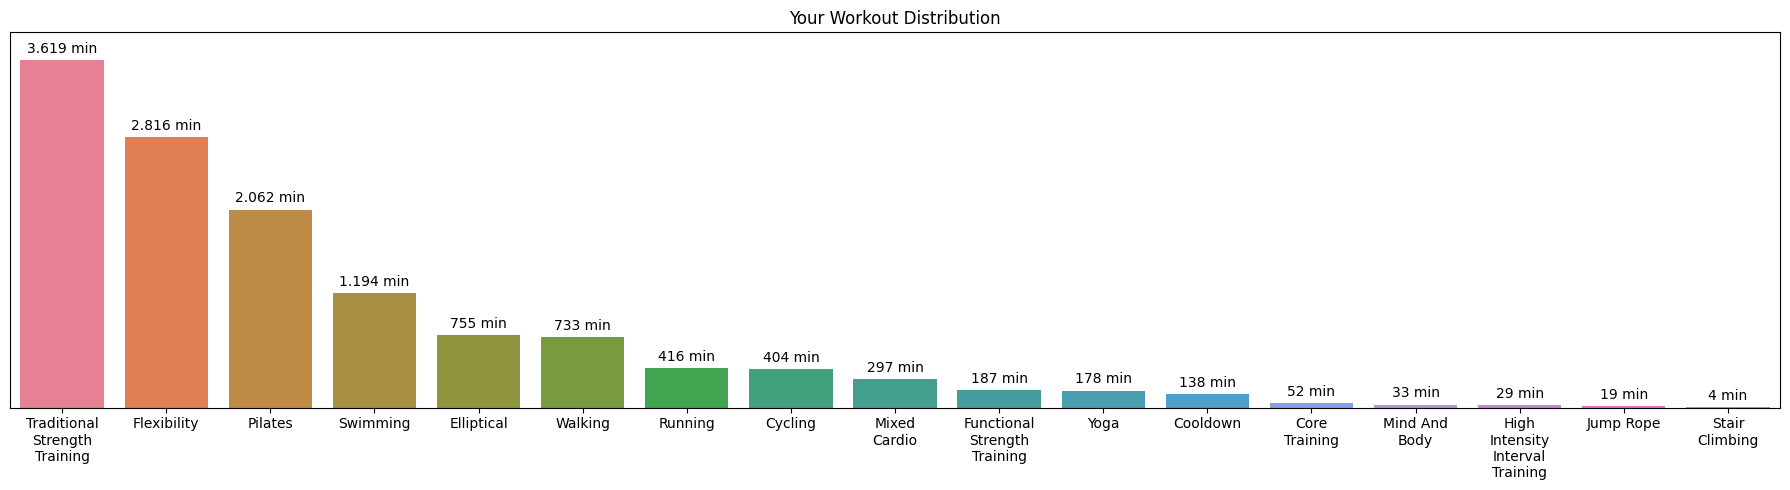

In [44]:
df_v2_gb = df_v2.groupby(['month', 'month_name', 'workoutActivityType']).agg({'duration': 'sum'}).reset_index()
df_v2_sport_time = df_v2.groupby(['workoutActivityType']).agg({'duration': 'sum'}).reset_index()
df_v2_sport_time = df_v2_sport_time.sort_values(by='duration', ascending=False)

fig, ax1 = plt.subplots(figsize=(18, 5))
lp_time_per_sport = sns.barplot(data=df_v2_sport_time, x='workoutActivityType', y='duration', hue='workoutActivityType');
ax1.yaxis.set_visible(False)
ax1.set_ylim()

labels = [textwrap.fill(label, width=11) for label in df_v2_sport_time['workoutActivityType']]  # Limitando a 14 caracteres e quebrando a linha
ax1.set_xticks(range(len(labels)))  # Definindo o número de ticks com base no número de rótulos
ax1.set_xticklabels(labels, rotation=0, fontdict={'fontsize': 10});  
ax1.set_xlabel('');
ax1.set_title('Your Workout Distribution')

y_max = df_v2_sport_time['duration'].max()
ax1.set_ylim(0, y_max * 1.08)

for container in lp_time_per_sport.containers:
    labels = [f'{v.get_height():,.0f} min'.replace(',', '.') if v.get_height() != 0 else '' for v in container]
    lp_time_per_sport.bar_label(container, labels=labels, padding=3, fontsize=10, bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0, edgecolor='none'))

img_buffer_2 = BytesIO()
plt.tight_layout()
plt.savefig(img_buffer_2, format='png', dpi=100)

Gerando o relatório:

In [45]:
def insert_table(sheet, table, dark, light):
    center_alignment = Alignment(horizontal='center', vertical='center')
    curr_row = sheet.max_row + 1

    # Insere o cabeçalho
    for i_col, col in enumerate(table.columns):
        sheet.cell(row=curr_row, column=i_col+3).value = col
        sheet.cell(row=curr_row, column=i_col+3).fill = PatternFill(start_color=dark, fill_type='solid')
        sheet.cell(row=curr_row, column=i_col+3).font = Font(bold=True)
        if i_col > 0: 
            sheet.cell(row=curr_row, column=i_col+3).alignment = center_alignment
    sheet.cell(row=curr_row, column=2).fill = PatternFill(start_color=dark, fill_type='solid')

    # Insere os dados
    next_row = curr_row + 1
    for i_row in range(table.shape[0]):
        sheet.cell(row=i_row+next_row, column=2).value = i_row+1 # Insere as posições
        sheet.cell(row=i_row+next_row, column=2).fill = PatternFill(start_color=dark, fill_type='solid')
        sheet.cell(row=i_row+next_row, column=2).alignment = center_alignment
        for i_col in range(table.shape[1]):
            value = table.iloc[i_row, i_col]
            sheet.cell(row=i_row+next_row, column=i_col+3).fill = PatternFill(start_color=light, fill_type='solid')
            if i_col > 0:
                sheet.cell(row=i_row+next_row, column=i_col+3).value = value
                sheet.cell(row=i_row+next_row, column=i_col+3).number_format = '#,##0'
                sheet.cell(row=i_row+next_row, column=i_col+3).alignment = center_alignment
            else:
                sheet.cell(row=i_row+next_row, column=i_col+3).value = value
                sheet.cell(row=i_row+next_row, column=i_col+3).alignment = Alignment(vertical='center', wrap_text=True)

    return sheet

In [46]:
wb = Workbook()
sheet = wb.active

sheet.sheet_view.showGridLines = False
sheet.title = 'Fitness'

sheet.column_dimensions['A'].width = 10
sheet.column_dimensions['B'].width = 4
for col in ['C', 'D', 'E', 'F']:
    sheet.column_dimensions[col].width = 16

sheet.cell(row=1, column=1).value = 'WORKOUT REPORT'
sheet.cell(row=1, column=1).font = Font(size=28, name='Bahnschrift Light')

sheet.cell(row=3, column=1).value = 'YOUR INFO:'
sheet.cell(row=3, column=1).font = Font(size=14, name='Bahnschrift Light')


dark_orange  = 'F1A983'
light_orange = 'FDF0E9'
dark_blue    = 'A6C9EC'
light_blue   = 'EBF3FB'
center_alignment = Alignment(horizontal='center', vertical='center')

sheet.row_dimensions[4].height = 9

# Year general info:
sheet.cell(row=5, column=1).value       = search_year
sheet.cell(row=5, column=1).fill        = PatternFill(start_color='B5E6A2', fill_type='solid')
sheet.cell(row=5, column=1).alignment   = center_alignment
sheet.cell(row=5, column=2).value       = row_year_1

# Sports
sheet.cell(row=7, column=1).value       = 'Sports'
sheet.cell(row=7, column=1).fill        = PatternFill(start_color=dark_orange, fill_type='solid')
sheet.cell(row=7, column=1).alignment   = center_alignment
sheet.cell(row=7, column=2).value       = row_sports_1
sheet.cell(row=8, column=2).value       = row_sports_2
sheet.cell(row=9, column=2).value       = row_sports_3
sheet.cell(row=10, column=2).value      = row_sports_4
sheet.cell(row=12, column=2).value      = row_sports_5
sheet.cell(row=12, column=2).font       = Font(bold=True)
sheet = insert_table(sheet, table_sports_1, dark_orange, light_orange)

# Heart
sheet.cell(row=20, column=1).value     = 'Heart'
sheet.cell(row=20, column=1).fill      = PatternFill(start_color='E49EDD', fill_type='solid')
sheet.cell(row=20, column=1).alignment = center_alignment
sheet.cell(row=20, column=2).value     = row_heart_1
sheet.cell(row=21, column=2).value     = row_heart_2

# Calories
sheet.cell(row=23, column=1).value     = 'Calories'
sheet.cell(row=23, column=1).fill      = PatternFill(start_color='F5B20B', fill_type='solid')
sheet.cell(row=23, column=1).alignment = center_alignment
sheet.cell(row=23, column=2).value     = row_calories_1

# Days
sheet.cell(row=25, column=1).value     = 'Days'
sheet.cell(row=25, column=1).fill      = PatternFill(start_color=dark_blue, fill_type='solid')
sheet.cell(row=25, column=1).alignment = center_alignment
sheet.cell(row=25, column=2).value     = row_day_1
sheet.cell(row=26, column=2).value     = row_day_2
sheet.cell(row=28, column=2).value     = row_day_3
sheet = insert_table(sheet, table_day_1, dark_blue, light_blue)

curr_row = sheet.max_row + 3

sheet.cell(row=curr_row, column=2).value   = row_day_4
sheet.cell(row=curr_row+1, column=2).value = row_day_5
sheet.cell(row=curr_row+3, column=2).value = row_day_6
if not row_day_6.startswith('However'):
    sheet = insert_table(sheet, table_day_2, dark_blue, light_blue)

# Goals
curr_row = sheet.max_row + 2
sheet.cell(row=curr_row, column=1).value     = 'Goals'
sheet.cell(row=curr_row, column=1).fill      = PatternFill(start_color='E76B91', fill_type='solid')
sheet.cell(row=curr_row, column=1).alignment = center_alignment
sheet.cell(row=curr_row, column=2).value     = row_goals_1
sheet.cell(row=curr_row+1, column=2).value   = row_goals_2

# View
sheet.cell(row=curr_row+3, column=1).value     = 'View'
sheet.cell(row=curr_row+3, column=1).fill      = PatternFill(start_color='FCEB6A', fill_type='solid')
sheet.cell(row=curr_row+3, column=1).alignment = center_alignment
sheet.cell(row=curr_row+3, column=2).value     = row_view_1

img_1 = Image(img_buffer_1)
img_1.width = 730
img_1.height = 305
img_2 = Image(img_buffer_2)
img_2.width = 730
img_2.height = 205

row_img1 = curr_row+5
sheet.add_image(img_1, f'B{row_img1}')
sheet.add_image(img_2, f'B{row_img1+16}')

excel_title = f"{search_year}_fitness_report.xlsx"

In [47]:
wb.save(excel_title)